In [36]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt

In [37]:
class Encoder(nn.Module):
    def __init__(self, encoder_net):
        super(Encoder,self).__init__()
        self.encoder = encoder_net
    
    def encode(self, x):
        h_e = self.encoder(x)
        mu_e, log_var_e = torch.chunk(h_e,chunks=2)
        return mu_e, log_var_e
    
    def sample(self, mu_e, log_var_e):
        std = torch.exp(0.5*log_var_e)
        eps = torch.randn_like(std)
        z = mu_e+std*eps
        return z
    
    def log_prob(self, mu_e, log_var_e, z): 
        return Normal(mu_e, torch.exp(log_var_e)).log_prob(z)

In [38]:
class Decoder(nn.Module):
    def __init__(self,decoder_net):
        super(Decoder,self).__init__()
        self.decoder = decoder_net

    def decode(self,z):
        h_d = self.decoder(z)
        return F.softmax(h_d)
    
    def log_prob(self,x,z):
        mu = self.decode(z)
        if x[0] == 1:
            return torch.log(mu[0])
        elif x[1] == 1:
            return torch.log(mu[1])
        elif x[2] == 1:
            return torch.log(mu[2])
        elif x[3] == 1:
            return torch.log(mu[3])


In [39]:
class VAE(nn.Module):
    def __init__(self,encoder_net,decoder_net,prior,latent_n=2):
        super(VAE,self).__init__()
        self.encoder = Encoder(encoder_net)
        self.decoder = Decoder(decoder_net)
        self.Prior = prior
        
    def forward(self, x):
        mu_e, log_var_e = self.encoder.encode(x)
        z = self.encoder.sample(mu_e, log_var_e)
        RE = self.decoder.log_prob(x, z)
        KL = (self.Prior.log_prob(z) - self.encoder.log_prob(mu_e=mu_e, log_var_e=log_var_e, z=z)).sum(-1)
        ELBO = -(RE + KL).mean()
        return ELBO

In [122]:
def training(num_epochs, model, optimizer, data):
    losses = []
    for e in range(num_epochs):
        model.train()
        loss_e = 0
        for indx_batch, x in enumerate(data):
            loss = model.forward(x)
            optimizer.zero_grad()
            loss.backward(retain_graph = True)
            optimizer.step()
            loss_e += loss.detach()
        losses.append(loss_e*0.25)
    return losses

In [137]:
latent_n = 2
encoder = nn.Sequential(nn.Linear(4,500),nn.Tanh(),nn.Linear(500,500),nn.Tanh(),nn.Linear(500,2*latent_n))
decoder = nn.Sequential(nn.Linear(latent_n,500),nn.Tanh(),nn.Linear(500,500),nn.Tanh(),nn.Linear(500,4))
prior = Normal(torch.zeros(latent_n),torch.ones(latent_n))
vae = VAE(encoder, decoder, prior)

In [138]:
e1 = torch.tensor([1.0,0.0,0.0,0.0])
e2 = torch.tensor([0.0,1.0,0.0,0.0])
e3 = torch.tensor([0.0,0.0,1.0,0.0])
e4 = torch.tensor([0.0,0.0,0.0,1.0])

In [139]:
onehot = [e1, e2, e3, e4]
num_epochs = 1000
lr = 10e-7
optimizer = torch.optim.Adam([p for p in vae.parameters() if p.requires_grad == True], lr=lr)
losses = training(num_epochs, vae, optimizer, onehot)

/var/folders/6p/lpk5hghs3pz6jwr7ngwtcnsw0000gn/T/ipykernel_16385/656875807.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(h_d)


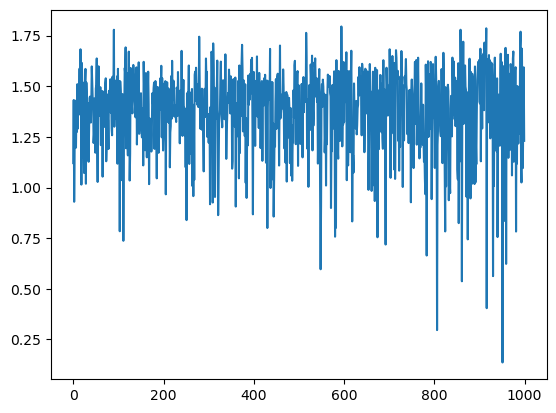

In [140]:
plt.plot(losses)

In [141]:
n = 200
samples = []
for i in range(4):
    mu_e, log_e = vae.encoder.encode(onehot[i])
    print(mu_e)
    print(log_e)
    samples.append([[],[]])
    for _ in range(n):
        s = vae.encoder.sample(mu_e,log_e).detach()
        samples[i][0].append(s[0])
        samples[i][1].append(s[1])


tensor([-0.0329, -0.0001], grad_fn=<SplitBackward0>)
tensor([-0.3243, -0.0430], grad_fn=<SplitBackward0>)
tensor([ 0.0185, -0.0604], grad_fn=<SplitBackward0>)
tensor([-0.3123,  0.0164], grad_fn=<SplitBackward0>)
tensor([-0.0010,  0.0151], grad_fn=<SplitBackward0>)
tensor([-0.3253, -0.0290], grad_fn=<SplitBackward0>)
tensor([0.0460, 0.0616], grad_fn=<SplitBackward0>)
tensor([-0.4255,  0.0977], grad_fn=<SplitBackward0>)


In [142]:
mu_e, log_e = vae.encoder.encode(onehot[0])
print(mu_e)
print(log_e)
for i in range(10):
    print(vae.encoder.sample(mu_e,log_e).detach())

tensor([-0.0329, -0.0001], grad_fn=<SplitBackward0>)
tensor([-0.3243, -0.0430], grad_fn=<SplitBackward0>)
tensor([0.2656, 0.8467])
tensor([0.3855, 0.4747])
tensor([ 0.0818, -0.0246])
tensor([ 0.5834, -0.4861])
tensor([0.5697, 0.6191])
tensor([-1.1749, -0.9996])
tensor([0.0394, 0.5160])
tensor([-0.6904,  1.9522])
tensor([0.1268, 0.2236])
tensor([ 0.3447, -0.0630])


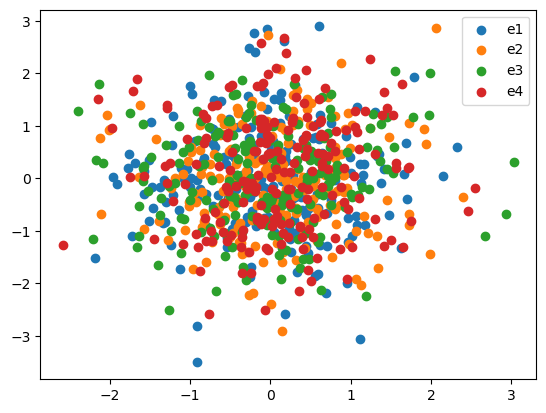

In [143]:
import matplotlib.pyplot as plt
plt.scatter(samples[0][0],samples[0][1],label="e1")
plt.scatter(samples[1][0],samples[1][1],label="e2")
plt.scatter(samples[2][0],samples[2][1],label="e3")
plt.scatter(samples[3][0],samples[3][1],label="e4")
plt.legend()
plt.show()